<a href="https://colab.research.google.com/github/eridanletalis/GB_nn/blob/main/hw4_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Загрузка библиотек и примеров

In [1]:
import cv2
from scipy import misc
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Input
from tensorflow.keras.layers import GlobalMaxPooling2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D 
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models, layers
import tensorflow.keras as keras
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Dense, Flatten, Concatenate
from tensorflow.keras.utils import plot_model 
from __future__ import print_function
#import tensorflow.keras as keras # расскоментируйте эту строку, чтобы начать обучение
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dropout, Activation
import os



In [2]:
classes=['самолет', 'автомобиль', 'птица', 'кот', 'олень', 'собака', 'лягушка', 'лошадь', 'корабль', 'грузовик']


In [3]:
batch_size = 32
num_classes = 10
epochs = 5
data_augmentation = False
num_predictions = 20

In [4]:
# разделение тренировочной и тестовой выборки
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'тренировочные примеры')
print(x_test.shape[0], 'тестовые примеры')

# преобразование матрицы чисел 0-9 в бинарную матрицу чисел 0-1
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255



x_train shape: (50000, 32, 32, 3)
50000 тренировочные примеры
10000 тестовые примеры


In [5]:
x_train.shape[1:]

(32, 32, 3)

In [6]:
import pandas as pd

In [7]:
column = ['resnet-like_base', 
          'resnet-like_more_krnl_1','resnet-like_more_krnl_2', 
          'resnet-like_deep_1', 'resnet-like_deep_2']

test_loss = pd.DataFrame(columns=column)
test_acc = pd.DataFrame(columns=column)

In [8]:
test_loss

,resnet-like_base,resnet-like_more_krnl_1,resnet-like_more_krnl_2,resnet-like_deep_1,resnet-like_deep_2


Не выполняется аугментация для увеличения скорости.
По этой же причине не делается несколько запусков - колаб отказывается переваритьвать в своём ОЗУ иначе.

После каждой модели перед обучением строится её схема.
Базовая модель представляет собой два входа с разными сетями - одна сеть имеет два сёрточных слоя, вторая - один, но большой. 
Далее следуют две модели с увеличением количества глубин: к каждой нити добавляется по одному, затем по два слоя; затем две модели, в которых увеличивается нить сначала для первой (три нити), потом для второй (четыре нити). Резульататы сведены в таблицу после эксперимента.  

Обрабатывается базовая модель


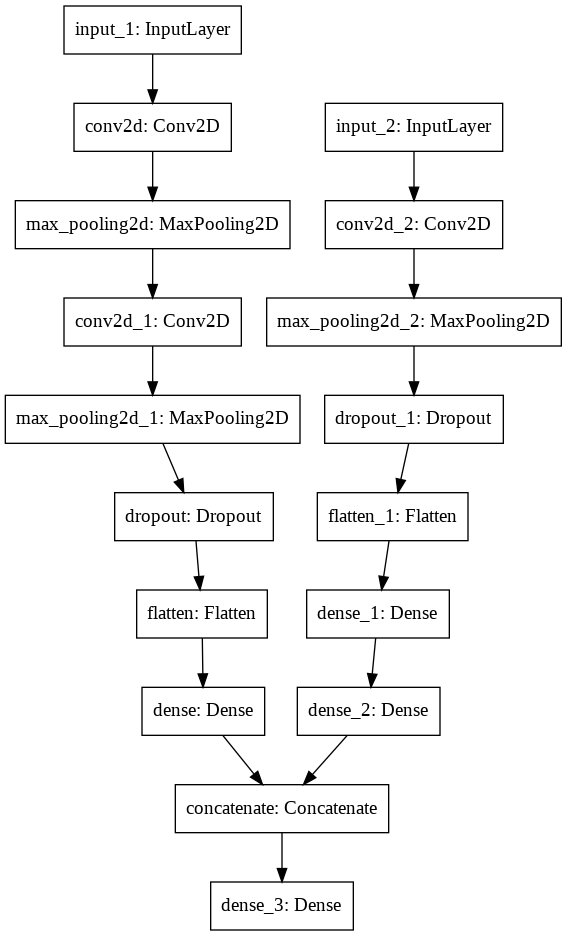

In [9]:
print("Обрабатывается базовая модель")
first_input = Input(shape=(32, 32, 3))
x11 = Conv2D(16,(3,3),activation='relu')(first_input)
x11 = MaxPooling2D(pool_size=(2,2),padding='same')(x11)
x11 = Conv2D(64,(3,3),activation='relu')(x11)
x11 = MaxPooling2D(pool_size=(2,2),padding='same')(x11)
x11 = Dropout( 0.25)(x11)
x11 = Flatten()(x11)
first_dense = Dense(128, activation='relu')(x11)

second_input = Input(shape=(32, 32, 3))
x21 = Conv2D(128,(3,3),activation='relu')(second_input)
x21 = MaxPooling2D(pool_size=(2,2),padding='same')(x21)
x21 = Dropout( 0.25)(x21)
x21 = Flatten()(x21)
x21 = Dense(512, )(x21)
second_dense = Dense(128, activation='relu')(x21)

merge = Concatenate( )([first_dense, second_dense])

merge = Dense(10, activation='softmax')(merge)


model_stek = Model(inputs=[first_input, second_input], outputs=merge)
ada_grad = tf.keras.optimizers.Adagrad(lr=0.1, epsilon=1e-08, decay=0.0)
model_stek.compile(optimizer=ada_grad, loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

plot_model(model_stek)


In [11]:
model_stek.fit(x =(x_train, x_train), y = y_train, epochs=epochs,validation_data=((x_test, x_test), y_test), workers=4)

# проверка работы обученной модели
scores = model_stek.evaluate((x_test, x_test), y_test, verbose=1)
test_loss.loc[1, column[0]] = scores[0]
test_acc.loc[1, column[0]] = scores[1]

Epoch 1/5
1563/1563 [==============================] - 10s 6ms/step - loss: 0.6063 - accuracy: 0.7862 - val_loss: 0.9878 - val_accuracy: 0.6723
Epoch 2/5
1563/1563 [==============================] - 10s 6ms/step - loss: 0.5105 - accuracy: 0.8190 - val_loss: 0.9851 - val_accuracy: 0.6862
Epoch 3/5
1563/1563 [==============================] - 10s 6ms/step - loss: 0.4296 - accuracy: 0.8489 - val_loss: 1.0073 - val_accuracy: 0.6915
Epoch 4/5
1563/1563 [==============================] - 10s 6ms/step - loss: 0.3584 - accuracy: 0.8735 - val_loss: 1.0531 - val_accuracy: 0.6955
Epoch 5/5
313/313 [==============================] - 1s 3ms/step - loss: 1.1305 - accuracy: 0.6834


Увеличение глубины сети 1


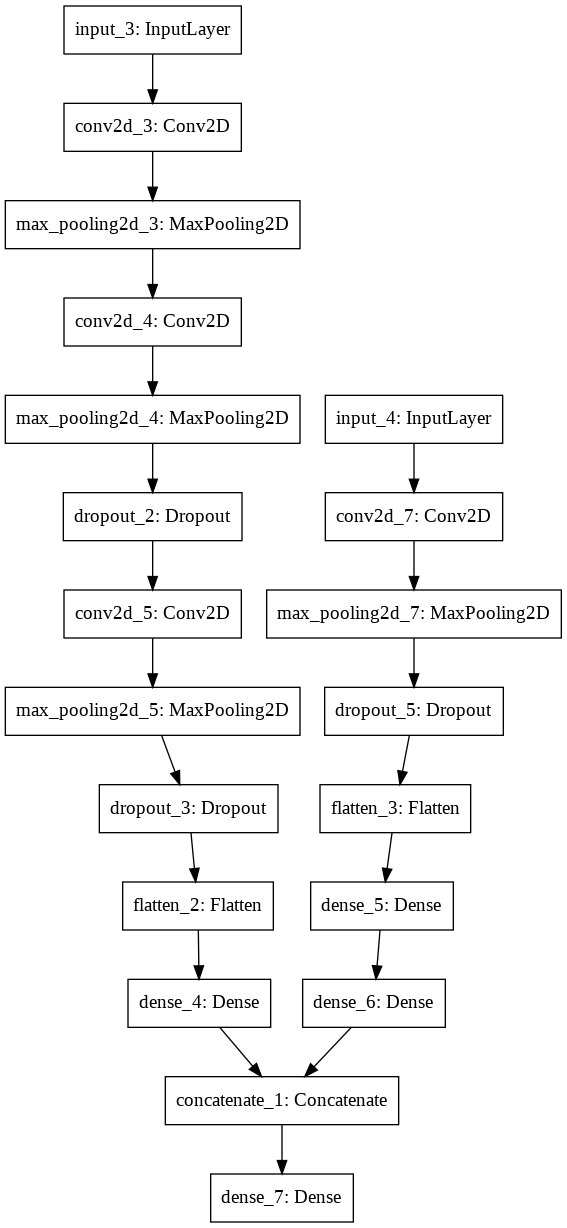

In [12]:
print("Увеличение глубины сети 1")
first_input = Input(shape=(32, 32, 3))
x11 = Conv2D(16,(3,3),activation='relu')(first_input)
x11 = MaxPooling2D(pool_size=(2,2),padding='same')(x11)
x11 = Conv2D(64,(3,3),activation='relu')(x11)
x11 = MaxPooling2D(pool_size=(2,2),padding='same')(x11)
x11 = Dropout( 0.25)(x11)
x11 = Conv2D(64,(3,3),activation='relu')(x11)
x11 = MaxPooling2D(pool_size=(2,2),padding='same')(x11)
x11 = Dropout( 0.25)(x11)
x11 = Flatten()(x11)
first_dense = Dense(128, activation='relu')(x11)

second_input = Input(shape=(32, 32, 3))
x21 = Conv2D(128,(3,3),activation='relu')(second_input)
x21 = MaxPooling2D(pool_size=(2,2),padding='same')(x21)
x21 = Dropout( 0.25)(x21)
x21 = Conv2D(128,(3,3),activation='relu')(second_input)
x21 = MaxPooling2D(pool_size=(2,2),padding='same')(x21)
x21 = Dropout( 0.25)(x21)
x21 = Flatten()(x21)
x21 = Dense(512, )(x21)
second_dense = Dense(128, activation='relu')(x21)

merge = Concatenate( )([first_dense, second_dense])

merge = Dense(10, activation='softmax')(merge)


model_stek = Model(inputs=[first_input, second_input], outputs=merge)
ada_grad = tf.keras.optimizers.Adagrad(lr=0.1, epsilon=1e-08, decay=0.0)
model_stek.compile(optimizer=ada_grad, loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
plot_model(model_stek)


In [13]:
model_stek.fit(x = [x_train, x_train], y = y_train, epochs=epochs,validation_data=((x_test, x_test), y_test), workers=4)
i = 1
# проверка работы обученной модели
scores = model_stek.evaluate((x_test, x_test), y_test, verbose=1)
test_loss.loc[i, column[1]] = scores[0]
test_acc.loc[i, column[1]] = scores[1]


Epoch 1/5
1563/1563 [==============================] - 11s 6ms/step - loss: 1.9748 - accuracy: 0.2732 - val_loss: 1.4339 - val_accuracy: 0.4787
Epoch 2/5
1563/1563 [==============================] - 10s 6ms/step - loss: 1.3403 - accuracy: 0.5196 - val_loss: 1.3566 - val_accuracy: 0.5279
Epoch 3/5
1563/1563 [==============================] - 10s 6ms/step - loss: 1.1505 - accuracy: 0.5943 - val_loss: 1.1875 - val_accuracy: 0.5825
Epoch 4/5
1563/1563 [==============================] - 10s 6ms/step - loss: 1.0302 - accuracy: 0.6371 - val_loss: 1.1146 - val_accuracy: 0.6155
Epoch 5/5
313/313 [==============================] - 1s 3ms/step - loss: 1.1645 - accuracy: 0.6074


Увеличение глубины сети 2


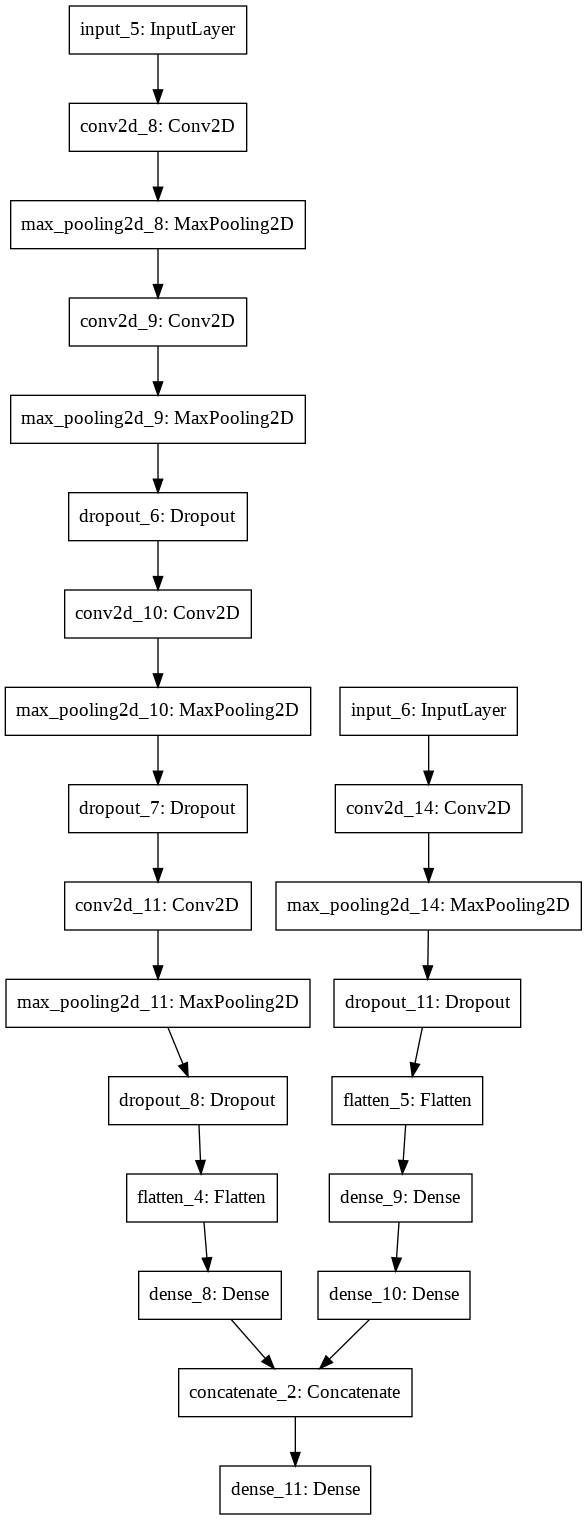

In [14]:
print("Увеличение глубины сети 2")
first_input = Input(shape=(32, 32, 3))
x11 = Conv2D(16,(3,3),activation='relu')(first_input)
x11 = MaxPooling2D(pool_size=(2,2),padding='same')(x11)
x11 = Conv2D(64,(3,3),activation='relu')(x11)
x11 = MaxPooling2D(pool_size=(2,2),padding='same')(x11)
x11 = Dropout( 0.25)(x11)
x11 = Conv2D(64,(3,3),activation='relu')(x11)
x11 = MaxPooling2D(pool_size=(2,2),padding='same')(x11)
x11 = Dropout( 0.25)(x11)
x11 = Conv2D(64,(3,3),activation='relu')(x11)
x11 = MaxPooling2D(pool_size=(2,2),padding='same')(x11)
x11 = Dropout( 0.25)(x11)
x11 = Flatten()(x11)
first_dense = Dense(128, activation='relu')(x11)

second_input = Input(shape=(32, 32, 3))
x21 = Conv2D(128,(3,3),activation='relu')(second_input)
x21 = MaxPooling2D(pool_size=(2,2),padding='same')(x21)
x21 = Dropout( 0.25)(x21)
x21 = Conv2D(128,(3,3),activation='relu')(second_input)
x21 = MaxPooling2D(pool_size=(2,2),padding='same')(x21)
x21 = Dropout( 0.25)(x21)
x21 = Conv2D(128,(3,3),activation='relu')(second_input)
x21 = MaxPooling2D(pool_size=(2,2),padding='same')(x21)
x21 = Dropout( 0.25)(x21)
x21 = Flatten()(x21)
x21 = Dense(512, )(x21)
second_dense = Dense(128, activation='relu')(x21)

merge = Concatenate( )([first_dense, second_dense])

merge = Dense(10, activation='softmax')(merge)


model_stek = Model(inputs=[first_input, second_input], outputs=merge)
ada_grad = tf.keras.optimizers.Adagrad(lr=0.1, epsilon=1e-08, decay=0.0)
model_stek.compile(optimizer=ada_grad, loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
plot_model(model_stek)



In [15]:
model_stek.fit(x = (x_train, x_train), y = y_train, epochs=epochs,validation_data=((x_test, x_test), y_test), workers=4)

# проверка работы обученной модели
scores = model_stek.evaluate((x_test, x_test), y_test, verbose=1)
print(scores)
test_loss.loc[i, column[2]] = scores[0]
test_acc.loc[i, column[2]] = scores[1]

Epoch 1/5
1563/1563 [==============================] - 11s 7ms/step - loss: 1.9469 - accuracy: 0.2801 - val_loss: 1.4116 - val_accuracy: 0.4957
Epoch 2/5
1563/1563 [==============================] - 10s 6ms/step - loss: 1.3557 - accuracy: 0.5191 - val_loss: 1.2365 - val_accuracy: 0.5635
Epoch 3/5
1563/1563 [==============================] - 10s 7ms/step - loss: 1.1776 - accuracy: 0.5832 - val_loss: 1.2056 - val_accuracy: 0.5739
Epoch 4/5
1563/1563 [==============================] - 10s 7ms/step - loss: 1.0337 - accuracy: 0.6327 - val_loss: 1.0867 - val_accuracy: 0.6202
Epoch 5/5
313/313 [==============================] - 1s 3ms/step - loss: 1.0631 - accuracy: 0.6227
[1.0631309747695923, 0.6226999759674072]


Увеличение ширины сети 1


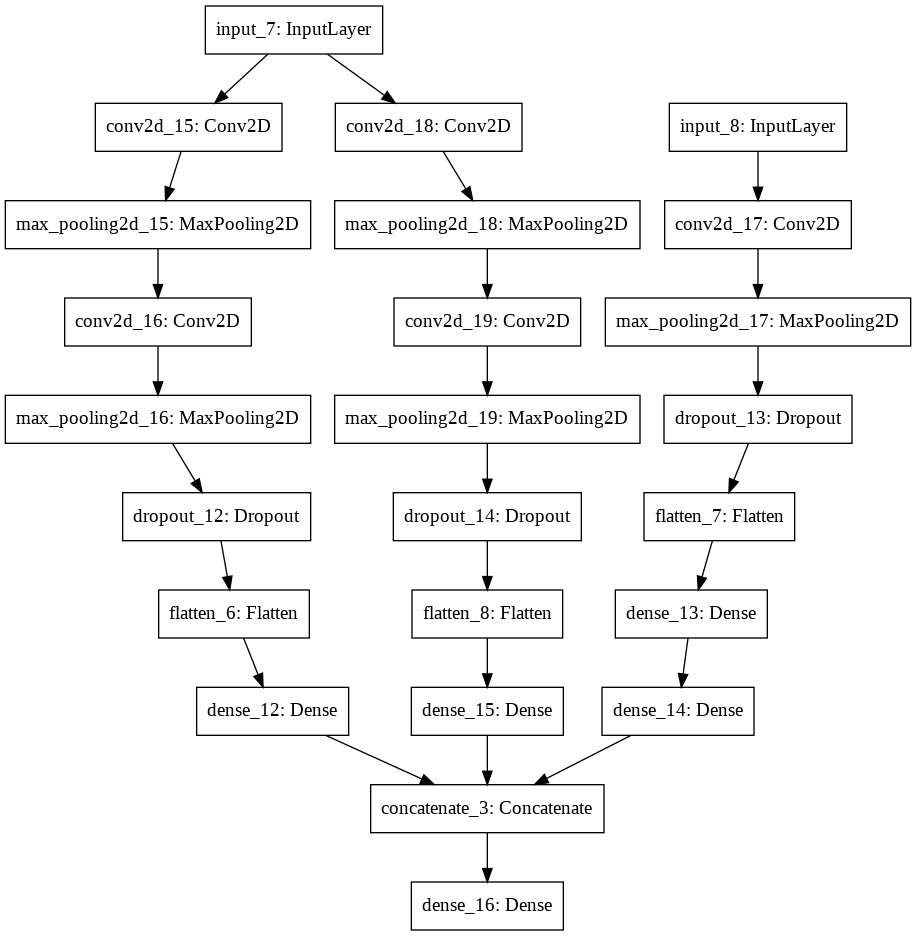

In [16]:
print("Увеличение ширины сети 1")
first_input = Input(shape=(32, 32, 3))
x11 = Conv2D(16,(3,3),activation='relu')(first_input)
x11 = MaxPooling2D(pool_size=(2,2),padding='same')(x11)
x11 = Conv2D(64,(3,3),activation='relu')(x11)
x11 = MaxPooling2D(pool_size=(2,2),padding='same')(x11)
x11 = Dropout( 0.25)(x11)
x11 = Flatten()(x11)
first_dense = Dense(128, activation='relu')(x11)

second_input = Input(shape=(32, 32, 3))
x21 = Conv2D(128,(3,3),activation='relu')(second_input)
x21 = MaxPooling2D(pool_size=(2,2),padding='same')(x21)
x21 = Dropout( 0.25)(x21)
x21 = Flatten()(x21)
x21 = Dense(512, )(x21)
second_dense = Dense(128, activation='relu')(x21)

# merge = Concatenate( )([first_dense, second_dense])

x31 = Conv2D(16,(3,3),activation='relu')(first_input)
x31 = MaxPooling2D(pool_size=(2,2),padding='same')(x31)
x31 = Conv2D(64,(3,3),activation='relu')(x31)
x31 = MaxPooling2D(pool_size=(2,2),padding='same')(x31)
x31 = Dropout( 0.25)(x31)
x31 = Flatten()(x31)
third_dense = Dense(128, activation='relu')(x31)

merge_2 = Concatenate()([first_dense, second_dense, third_dense])

merge_2 = Dense(10, activation='softmax')(merge_2)


model_stek = Model(inputs=[first_input, second_input], outputs=merge_2)
ada_grad = tf.keras.optimizers.Adagrad(lr=0.1, epsilon=1e-08, decay=0.0)
model_stek.compile(optimizer=ada_grad, loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
plot_model(model_stek)


In [18]:
model_stek.fit(x = (x_train, x_train), y = y_train, epochs=epochs,validation_data=((x_test, x_test), y_test), workers=4)

# проверка работы обученной модели
scores = model_stek.evaluate((x_test, x_test), y_test, verbose=1)
print(scores)
test_loss.loc[i, column[3]] = scores[0]
test_acc.loc[i, column[3]] = scores[1]


313/313 [==============================] - 1s 4ms/step - loss: 0.8948 - accuracy: 0.7017
[0.8947936296463013, 0.70169997215271]


Увеличение ширины сети 2


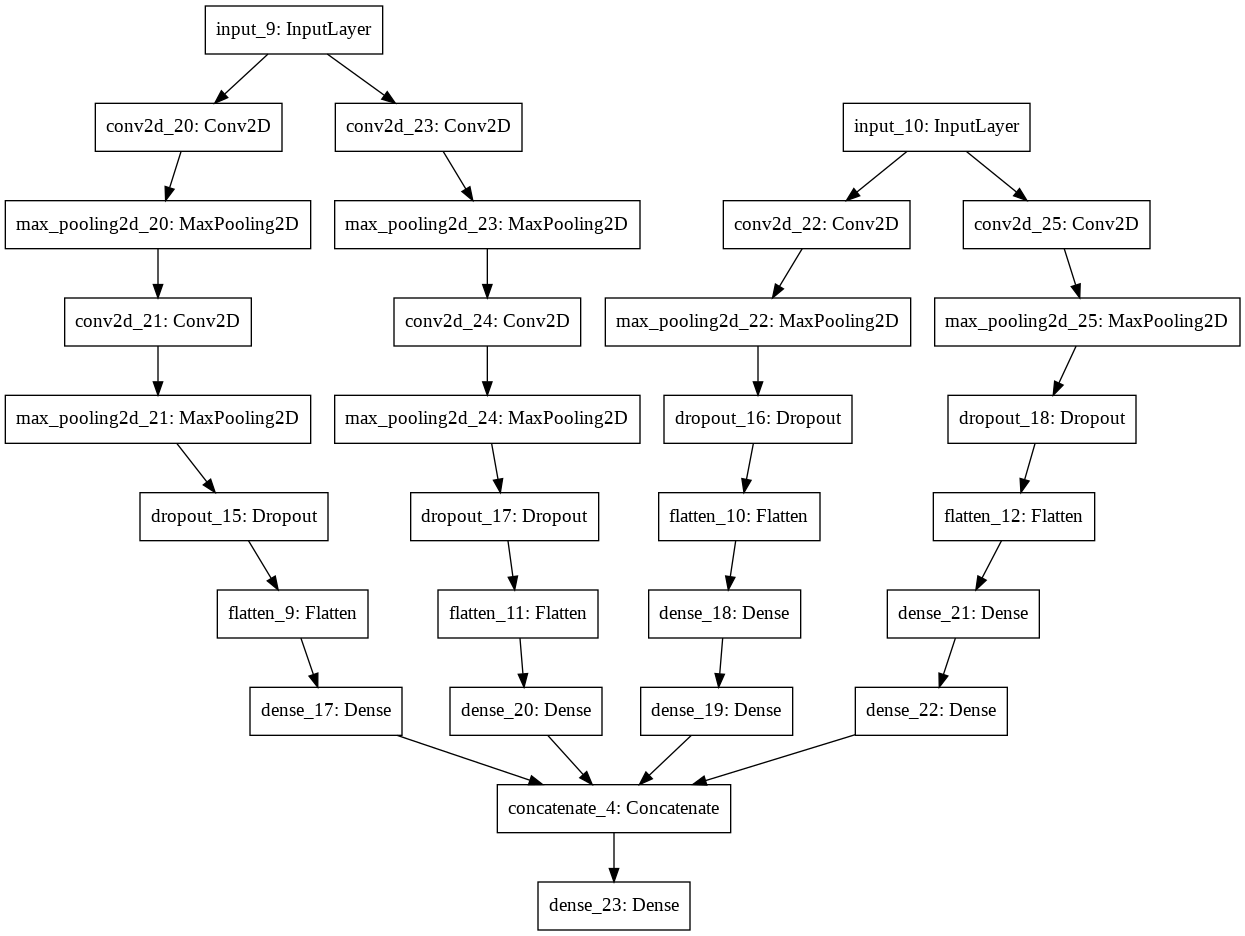

In [19]:
print("Увеличение ширины сети 2")
first_input = Input(shape=(32, 32, 3))
x11 = Conv2D(16,(3,3),activation='relu')(first_input)
x11 = MaxPooling2D(pool_size=(2,2),padding='same')(x11)
x11 = Conv2D(64,(3,3),activation='relu')(x11)
x11 = MaxPooling2D(pool_size=(2,2),padding='same')(x11)
x11 = Dropout( 0.25)(x11)
x11 = Flatten()(x11)
first_dense = Dense(128, activation='relu')(x11)

second_input = Input(shape=(32, 32, 3))
x21 = Conv2D(128,(3,3),activation='relu')(second_input)
x21 = MaxPooling2D(pool_size=(2,2),padding='same')(x21)
x21 = Dropout( 0.25)(x21)
x21 = Flatten()(x21)
x21 = Dense(512, )(x21)
second_dense = Dense(128, activation='relu')(x21)

# merge = Concatenate( )([first_dense, second_dense])

x31 = Conv2D(16,(3,3),activation='relu')(first_input)
x31 = MaxPooling2D(pool_size=(2,2),padding='same')(x31)
x31 = Conv2D(64,(3,3),activation='relu')(x31)
x31 = MaxPooling2D(pool_size=(2,2),padding='same')(x31)
x31 = Dropout( 0.25)(x31)
x31 = Flatten()(x31)
third_dense = Dense(128, activation='relu')(x31)

x41 = Conv2D(128,(3,3),activation='relu')(second_input)
x41 = MaxPooling2D(pool_size=(2,2),padding='same')(x41)
x41 = Dropout( 0.25)(x41)
x41 = Flatten()(x41)
x41 = Dense(512, )(x41)
fourth_dense = Dense(128, activation='relu')(x41)

merge_2 = Concatenate()([first_dense, second_dense, third_dense, fourth_dense])

merge_2 = Dense(10, activation='softmax')(merge_2)


model_stek = Model(inputs=[first_input, second_input], outputs=merge_2)
ada_grad = tf.keras.optimizers.Adagrad(lr=0.1, epsilon=1e-08, decay=0.0)
model_stek.compile(optimizer=ada_grad, loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
plot_model(model_stek)

In [20]:
model_stek.fit(x = (x_train, x_train), y = y_train, epochs=epochs,validation_data=((x_test, x_test), y_test), workers=4)

# проверка работы обученной модели
scores = model_stek.evaluate((x_test, x_test), y_test, verbose=1)
print(scores)
test_loss.loc[i, column[4]] = scores[0]
test_acc.loc[i, column[4]] = scores[1]

Epoch 1/5
1563/1563 [==============================] - 16s 10ms/step - loss: 1.7977 - accuracy: 0.3441 - val_loss: 1.2085 - val_accuracy: 0.5735
Epoch 2/5
1563/1563 [==============================] - 15s 10ms/step - loss: 1.0938 - accuracy: 0.6127 - val_loss: 1.0097 - val_accuracy: 0.6452
Epoch 3/5
1563/1563 [==============================] - 15s 10ms/step - loss: 0.8645 - accuracy: 0.6986 - val_loss: 0.9319 - val_accuracy: 0.6729
Epoch 4/5
1563/1563 [==============================] - 15s 10ms/step - loss: 0.7004 - accuracy: 0.7553 - val_loss: 0.8665 - val_accuracy: 0.6982
Epoch 5/5
313/313 [==============================] - 1s 4ms/step - loss: 0.9625 - accuracy: 0.6752
[0.9624788165092468, 0.6751999855041504]


In [22]:
test_loss

,resnet-like_base,resnet-like_more_krnl_1,resnet-like_more_krnl_2,resnet-like_deep_1,resnet-like_deep_2
1,1.13051,1.16445,1.06313,0.894794,0.962479


In [23]:
test_acc

,resnet-like_base,resnet-like_more_krnl_1,resnet-like_more_krnl_2,resnet-like_deep_1,resnet-like_deep_2
1,0.6834,0.6074,0.6227,0.7017,0.6752


В заголовках таблицы допущены ошибки.
resnet-like_more_krnl_N на самом деле - увеличение глубины сети, resnet-like_deep_N - увеличение её ширины.

Мы видим, что увеличение глубины сети не даёт большой прирост к точности, даже наоборот. Это может быть вызвано малым числом обучающей выборки.

Также, сильно широкая сеть не даст больших преимуществ - сеть с тремя нитями оказалась лучше, чем базовая и чем с четырьмя. 
Очевидно, что для каждого набора данных следует подбирать сеть экспериментально, сначала в ширину, а затем вглубь, если позволяет количество сэмплов. 
